# Import Libraries and Load the Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Dataset .csv')

# Display first five rows to understand the data
df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


# Preprocess the Dataset

In [2]:
# checking for missing values
df.isnull().sum()

Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64

In [3]:
df.columns

Index(['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address',
       'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes'],
      dtype='object')

In [4]:
# handle missing values
df = df.dropna(subset=['Cuisines'])
# convert the Cuisines column to string
df['Cuisines'] = df['Cuisines'].astype(str)
# split Cuisines into lists
df['Cuisines'] = df['Cuisines'].str.split(', ')

# initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# encoding the column of Cuisines
cuisines_encoded = pd.DataFrame(mlb.fit_transform(df['Cuisines']), columns = mlb.classes_, index = df.index)

# combine encoded Cuisines with the original dataset
df = pd.concat([df, cuisines_encoded], axis=1)
# drop the original Cuisines column
df = df.drop('Cuisines', axis=1)

# select the important features for prediction
features = ['City', 'Average Cost for two', 'Has Table booking', 'Has Online delivery', 'Price range', 'Votes']

# limit the Cuisines to the top 10 to avoid too many features
top_cuisines = cuisines_encoded.sum().sort_values(ascending = False).head(10).index
features = features + list(top_cuisines)

# encode categorical variabes
le = LabelEncoder()
df['Has Table booking'] = df['Has Table booking'].map({'Yes': 1, 'No': 0})
df['Has Online delivery'] = df['Has Online delivery'].map({'Yes': 1, 'No': 0})
df['City'] = le.fit_transform(df['City'])

# Split the Data

In [5]:
X = df[features]
y = df['Aggregate rating']
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Numeric Features

In [6]:
scaler = StandardScaler()
numerical_features = ['Average Cost for two', 'Votes']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Train and Evaluate the Model

### XGBoost Regressor

In [7]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print({'Model': 'XGBoost', 'MSE': xgb_mse, 'R-squared': xgb_r2})

{'Model': 'XGBoost', 'MSE': 0.09242174973648931, 'R-squared': 0.959641724823559}


# The Importance Of Features (XGBoost)

In [8]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
})
print("\nThe importance of features (XGBoost):")
print(feature_importance.sort_values(by='Importance', ascending=False))


The importance of features (XGBoost):
                 Feature  Importance
5                  Votes    0.808441
7                Chinese    0.021682
6           North Indian    0.020709
4            Price range    0.019295
8              Fast Food    0.016676
0                   City    0.014801
14              Desserts    0.014661
12           Continental    0.014158
13                  Cafe    0.013979
3    Has Online delivery    0.013100
1   Average Cost for two    0.009740
2      Has Table booking    0.007171
15          South Indian    0.007115
9                Mughlai    0.006824
10               Italian    0.006407
11                Bakery    0.005240


# Plotting The Importance Of Features

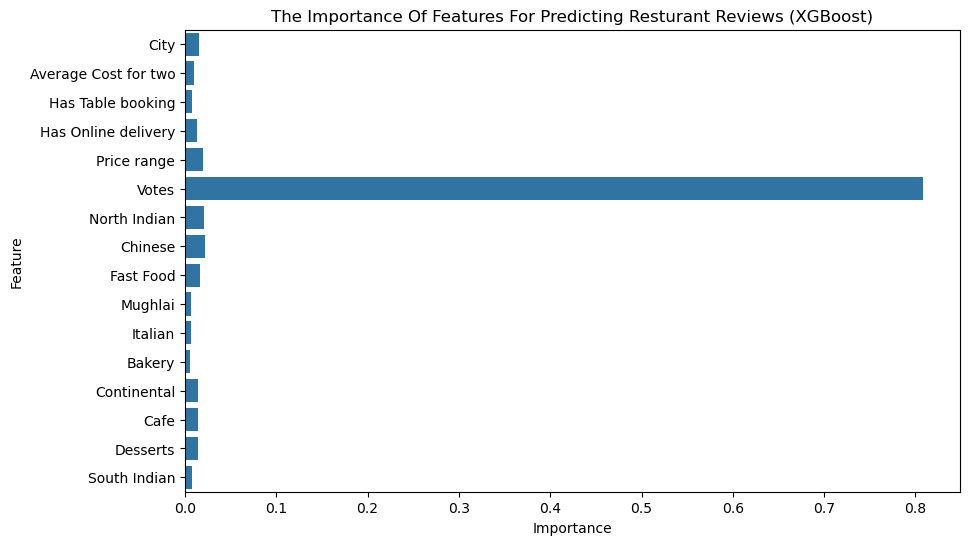

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('The Importance Of Features For Predicting Resturant Reviews (XGBoost)')
plt.show()